<a href="https://colab.research.google.com/github/Justawayx/microbe_tracking/blob/master/Find_coords_actual_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [ ]:
cd /content/drive/My\ Drive/image_segmentation/Data

/content/drive/My Drive/image_segmentation/Data


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import os, sys, math, cv2, glob, scipy, random as rand
from PIL import Image
from matplotlib import pyplot as plt
from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rotate
from scipy import ndimage, signal
from sklearn.model_selection import train_test_split

tf.compat.v1.disable_eager_execution()

In [ ]:
# ====================================
# Define preprocessing functions
# ====================================

def normalize_intensity(img):
  # Intensity normalization (linear)
  normMax, normMin = 1.0, 0.0
  normRange = normMax - normMin
  imgMax, imgMin = img.max(), img.min()
  imgRange = imgMax - imgMin
  img_norm = (img - imgMin) * (normRange/imgRange) + normMin
  return img_norm

def Gaussian(size,sigma):
    yi, xi = np.mgrid[0:size, 0:size] - np.floor(size/2) # Assumes odd size
    G = (1/(2*np.pi*(sigma**2)))*np.e**(-1*((xi**2)+(yi**2))/(2*(sigma**2)))
    return G

def preprocess(img):
    img_8u = np.uint8(img*255) # Range 0-255
    img_gray = cv2.cvtColor(img_8u, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    img_f1 = cv2.fastNlMeansDenoising(img_gray, None, h=12) # Denoise
    img_f2 = signal.convolve2d(img_f1, Gaussian(9, 2), mode='same') # Gaussian filter
    img_f3 = cv2.Laplacian(img_f2, cv2.CV_8U, ksize=5) # Laplacian filter
    # th_otsu = filters.threshold_otsu(img_f3) # Otsu threshold for background
    # img_f3[img_f3 <= th_otsu] = 0

    return img_f3

def get_images(img_dir):
    data_path = os.path.join(img_dir,'*g')
    files = sorted(glob.glob(data_path))
    imgs = [cv2.imread(file) for file in files]
    return np.array(imgs)

def develop_features_v2(img_dir, num_frames):
    data_path = os.path.join(img_dir,'*g')
    files = sorted(glob.glob(data_path))
    
    imgs_processed = []
    progress = 0
    for file in files:
        img = cv2.imread(file)
        img_norm = normalize_intensity(img)
        imgs_processed.append(preprocess(img_norm))
        progress += 1
        if progress % 10 == 0:
            print("Done processing %s images\r" % progress)
        if progress == num_frames:
            break

    
    imgs_processed = np.array(imgs_processed)
    m, n, o = imgs_processed.shape
    return np.reshape(imgs_processed, (m,n,o,1))

# centroid_locs, ploc should be numpy arrays
def min_edist_to_centroid(centroid_locs, ploc):
    ploc = ploc.reshape(1,2)
    diffs = scipy.spatial.distance.cdist(ploc,centroid_locs)
    return diffs.min()

def centroids_to_pmap(img_shape, centroid_locs):
    h = img_shape[0]
    w = img_shape[1]
    frame = np.zeros(img_shape)

    for index in np.ndindex(h,w):
        x, y = index
        frame[y, x] = math.exp(-1/50 * min_edist_to_centroid(centroid_locs, np.array(index)))
    return frame

def get_predeveloped_labels(folder_path = 'centroidPMaps/'):
    files = sorted([f for f in os.listdir(folder_path)])
    frames = list()
    for file in files:
      img = cv2.imread(folder_path + file)
      img_8u = np.uint8(img*255) # Range 0-255
      img_gray = cv2.cvtColor(img_8u, cv2.COLOR_BGR2GRAY) # Convert to grayscale
      frames.append(img_gray)    
    frames = np.array(frames)
    m,n,o = frames.shape
    return np.reshape(frames, (m,n,o,1))

def develop_labels(folder_path, img_shape):
    files = sorted([f for f in os.listdir(folder_path)])
    frames = list()
    
    progress = 0
    for file in files:
        frame = list()
        with open(folder_path + '/' + file, 'r') as f:
            cur_max = 0
            for line in f:
                x, y = line.split()
                frame.append((int(x), int(y)))
                cur_max += 1

            frame = np.array(frame)
            frames.append(centroids_to_pmap(img_shape, frame))
        progress += 1
        print("Done processing %s images\r" % progress)

    frames = np.array(frames)
    m,n,o = frames.shape

    return np.reshape(frames, (m,n,o,1))

def get_centroids(folder_path):
    files = sorted([f for f in os.listdir(folder_path)])
    frames = list()
    for file in files:
        frame = list()
        with open(folder_path + '/' + file, 'r') as f:
            for line in f:
                x, y = line.split()
                frame.append((int(x), int(y)))
            frame = np.array(frame)
            frames.append(frame)
    frames = np.array(frames)
    return frames

def get_centroid_counts(centroids = None):
  if centroids == None:
    centroids = get_centroids('newCentroids/')
  counts = []
  for centroid_set in centroids:
    counts.append(len(centroid_set))
  return counts

def develop_heatmap_labels(folder_path):
    files = sorted([f for f in os.listdir(folder_path)])
    num_maps = len(files)

    heat_maps = np.zeros((num_maps, 1024, 1024))
    mesh_grid = np.array(np.meshgrid([range(1024)],[range(1024)]), dtype='float32')
    mesh_grid = np.tile(np.reshape(mesh_grid, (1, 2, 1024, 1024)), (128,1,1,1))
    i = 0
    for file in files:
        with open(folder_path + '/' + file, 'r') as f:
            cur_max = 0
            labels = list()
            for line in f:
                x, y = line.split()
                labels.append((int(x), int(y)))
                cur_max += 1

            labels = np.pad(np.array(labels, dtype='float32'), ((0,128 - cur_max),(0,0)), mode='constant', constant_values=0)
            labels = np.reshape(labels, (128, 2, 1, 1))
            heat_maps[i,:,:] = np.exp(-1/50 * (np.min(np.sqrt(np.sum(np.square(mesh_grid - labels), axis=1)), axis=0)))
            i += 1

            if i % 10 == 0:
                print('Finished processing %s heatmaps.' % i)
    return heat_maps

def develop_random_heatmap_labels(num_maps):

    labels = np.random.randint(1024, size=(num_maps,128, 2, 1, 1)).astype('float32')
    heat_maps = np.zeros((num_maps, 1024, 1024))
    mesh_grid = np.array(np.meshgrid([range(1024)],[range(1024)]), dtype='float32')
    mesh_grid = np.tile(np.reshape(mesh_grid, (1, 2, 1024, 1024)), (128,1,1,1))


    for i in range(num_maps):
        print(i)
        num_zero_centroids = rand.randint(0, 128)
        labels[i,127-num_zero_centroids:128,:,:,:] = np.zeros((num_zero_centroids + 1,2,1,1))
        heat_maps[i,:,:] = np.exp(-1/50 * (np.min(np.sqrt(np.sum(np.square(mesh_grid - labels[i,:,:,:,:]), axis=1)), axis=0)))

    return heat_maps, labels

def crop_images(labels, features, num, with_mixup = False):
    labels_crop = list()
    features_crop = list()

    for i in range(num):
        while True:
            image = np.random.choice(labels.shape[0])
            x = np.random.choice(labels.shape[1] - 192) + 64
            y = np.random.choice(labels.shape[2] - 192) + 64

            if np.sum(labels[image, x:x+64,y:y+64, 0]) >= (64 ** 2) * 0.05:

                current_labels = labels[image, x:x+64,y:y+64, :]
                if with_mixup:
                    lam = np.reshape(np.random.beta(1, 1, 64*64), (64,64,1))
                    x_j = np.reshape(np.random.choice(64,64*64), (64,64,1))
                    y_j = np.reshape(np.random.choice(64,64*64), (64,64,1))
                    y_j = labels[image, x_j, y_j]
                    current_labels = np.where((1 - lam > 0.9) & (y_j == 1), 1, current_labels)

                labels_crop.append(current_labels)
                features_crop.append(features[image,x:x+64,y:y+64])
                break

    return np.asarray(labels_crop, dtype='uint8'), np.asarray(features_crop, dtype='uint8')

In [ ]:
# ======================
# Heatmap preprocessing
# ======================

def invert_and_scale_heatmaps(labels):
  labels_mod = []
  for label in labels:
    img = label[:,:,0]
    # Only invert if closest pixels have high values
    # and farthest/background pixels have low values;
    # Goal is for closest pixels to have value 0
    inverted_img = np.invert(img)
    scaled_img = np.exp((-1 * inverted_img / 25) + 2.2)
    h, w = scaled_img.shape
    labels_mod.append(scaled_img.reshape(h, w, 1))
  return np.array(labels_mod)

def threshold_heatmaps(labels, direction='>', threshold_frac=0.5):
  if direction not in ['>', '<']:
    print("Your options for direction are > or <")
    return None
  labels_mod = np.copy(labels)
  for i in range(len(labels_mod)):
    img = labels_mod[i][:,:,0]
    irange = img.max() - img.min()
    threshold = img.min() + threshold_frac*irange
    if direction == '>':
      img[img > threshold] = threshold
    elif direction == '<':
      img[img < threshold] = threshold
    labels_mod[i] = img.reshape(img.shape[0], img.shape[1], 1)
  return labels_mod

def normalize_heatmaps(labels):
  # Namely turn into 0-1
  labels_mod = []
  for label in labels:
    img = label[:,:,0]
    img = normalize_intensity(img)
    h, w = img.shape
    labels_mod.append(img.reshape(h, w, 1))
  return np.array(labels_mod)

In [ ]:
# ====================================
# Run preprocessing!
# ====================================

labels = get_predeveloped_labels()
labels = invert_and_scale_heatmaps(labels)
labels = threshold_heatmaps(labels, '<', 0.1)
labels = normalize_heatmaps(labels)
print(labels.shape)

features = develop_features_v2('newFrames/', labels.shape[0])
print(features.shape)

(201, 1024, 1024, 1)
Done processing 10 images
Done processing 20 images
Done processing 30 images
Done processing 40 images
Done processing 50 images
Done processing 60 images
Done processing 70 images
Done processing 80 images
Done processing 90 images
Done processing 100 images
Done processing 110 images
Done processing 120 images
Done processing 130 images
Done processing 140 images
Done processing 150 images
Done processing 160 images
Done processing 170 images
Done processing 180 images
Done processing 190 images
Done processing 200 images
(201, 1024, 1024, 1)


In [ ]:
def expand_data_rotate(features, labels):
  # Assume same number of features and labels
  num, h, w, d = features.shape
  extra_features = []
  extra_labels = []
  for i in range(num):
    orig_feature = features[i,:,:,0]
    orig_pmap = labels[i,:,:,0]
    rotated_feature = rotate(orig_feature, 90, preserve_range=True)
    rotated_pmap = rotate(orig_pmap, 90, preserve_range=True)
    extra_features.append(rotated_feature.reshape(h, w, 1))
    extra_labels.append(rotated_pmap.reshape(h, w, 1))
  extra_features = np.array(extra_features)
  extra_labels = np.array(extra_labels)
  return extra_features, extra_labels

In [ ]:
extra_features, extra_labels = expand_data_rotate(features, labels)

In [ ]:
new_features = np.concatenate((features, extra_features))
del extra_features
# del features

In [ ]:
new_labels = np.concatenate((labels, extra_labels))
del extra_labels
# del labels

In [ ]:
# Let train data be everything except
# 1 - 202, 43 - 244, 87 - 288, 122 - 323, 160 - 361, 199 - 400

test_indices = np.array([1, 202, 43, 244, 87, 288, 122, 323, 160, 361, 199, 400])
train_indices = np.setdiff1d(np.arange(0, 402), test_indices)

In [ ]:
# Create dict to map old indices (0-401) to new ones (0-389 train, 0-11 test)
old2test_idxs = {}

j = 0
for i in test_indices:
  old2test_idxs[i] = j
  j += 1

old2train_idxs = {}

j = 0
for i in train_indices:
  old2train_idxs[i] = j
  j += 1

In [ ]:
test_labels = new_labels[test_indices]
train_labels = new_labels[train_indices]

In [ ]:
test_features = new_features[test_indices]
train_features = new_features[train_indices]

In [ ]:
# ====================================
# Define loss functions and NN model
# ====================================


def Weighted_cross_entropy_loss(beta = 1):
  def convert_to_logits(y_pred):
      y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

      return tf.math.log(y_pred / (1 - y_pred))

  def loss(y_true, y_pred):
      y_pred = convert_to_logits(y_pred)
      loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, beta)

      # or reduce_sum and/or axis=-1
      return tf.reduce_mean(loss)

  return loss


def Dice_loss():
    def loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
        denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

        return 1 - (numerator + 1) / (denominator + 1)

    return loss


def Tversky_loss(beta):
    def loss(y_true, y_pred):
      numerator = tf.reduce_sum(y_true * y_pred, axis=-1)
      denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

      return 1 - (numerator + 1) / (tf.reduce_sum(denominator, axis=-1) + 1)

    return loss


def centroid_loss():
    def loss(y_true, y_pred):
        mesh_grid = tf.meshgrid(np.arange(0, 1024), np.arange(0, 1024))
        mesh_grid = tf.repeat(mesh_grid, repeats = 128, axis=0)
        distance = tf.min(tf.keras.backend.sum(tf.keras.backend.square(tf.keras.backend.reshape(y_true, (-1, 128, 1, 1)) - mesh_grid)), axis=0)

def code_block_encode(prev_layer, filters, regularizer):
    layer_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(prev_layer)   
    layer_2 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer)(layer_1)
    layer_3 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer)(layer_2)

    return layer_3


def code_block_decode(prev_layer, encoding_layer, filters, regularizer):
    layer_1 = tf.keras.layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=regularizer)(prev_layer)
    layer_2 = tf.keras.layers.concatenate([encoding_layer, layer_1])
    layer_3 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer)(layer_2)
    layer_4 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer)(layer_3)

    return layer_4


def create_UNet(img_dim, filters, regularizer, learning_rate):
    if regularizer == 'None':
        regularizer = None

    input = tf.keras.layers.Input(shape=img_dim[1:], dtype='float32')
    input_block = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer)(input)
    input_block = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer)(input_block)


    filters *=2
    encode_block1 = code_block_encode(input_block, filters, regularizer)
    filters *= 2
    encode_block2 = code_block_encode(encode_block1, filters, regularizer)
    filters *= 2
    encode_block3 = code_block_encode(encode_block2, filters, regularizer)
    filters *= 2
    descriptors = code_block_encode(encode_block3, filters, regularizer)
    filters /= 2
    decode_block3 = code_block_decode(descriptors, encode_block3, filters, regularizer)
    filters /= 2
    decode_block2 = code_block_decode(decode_block3, encode_block2, filters, regularizer)
    filters /= 2
    decode_block1 = code_block_decode(decode_block2, encode_block1, filters, regularizer)
    filters /= 2
    output = code_block_decode(decode_block1, input_block, filters, regularizer)
    output = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid', kernel_regularizer=regularizer)(output)

    model = tf.keras.Model(inputs=input, outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.TruePositives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model


def create_WNet(img_dim, filters, regularizer, learning_rate):
    if regularizer == 'None':
        regularizer = None

    input = tf.keras.layers.Input(shape=img_dim[1:], dtype='float32')
    input_block = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer)(input)
    input_block = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer)(input_block)


    filters *=2
    encode_block1 = code_block_encode(input_block, filters, regularizer)
    filters *= 2
    encode_block2 = code_block_encode(encode_block1, filters, regularizer)
    filters *= 2
    encode_block3 = code_block_encode(encode_block2, filters, regularizer)
    filters *= 2
    descriptors = code_block_encode(encode_block3, filters, regularizer)
    filters /= 2
    decode_block3 = code_block_decode(descriptors, encode_block3, filters, regularizer)
    filters /= 2
    decode_block2 = code_block_decode(decode_block3, encode_block2, filters, regularizer)
    filters /= 2
    decode_block1 = code_block_decode(decode_block2, encode_block1, filters, regularizer)
    filters /= 2
    output = code_block_decode(decode_block1, input_block, filters, regularizer)
    output = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid', kernel_regularizer=regularizer)(output)

    input_block2 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer)(output)
    input_block2 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer)(input_block2)


    filters *=2
    encode_block1 = code_block_encode(input_block2, filters, regularizer)
    filters *= 2
    encode_block2 = code_block_encode(encode_block1, filters, regularizer)
    filters *= 2
    encode_block3 = code_block_encode(encode_block2, filters, regularizer)
    filters *= 2
    descriptors = code_block_encode(encode_block3, filters, regularizer)
    filters /= 2
    decode_block3 = code_block_decode(descriptors, encode_block3, filters, regularizer)
    filters /= 2
    decode_block2 = code_block_decode(decode_block3, encode_block2, filters, regularizer)
    filters /= 2
    decode_block1 = code_block_decode(decode_block2, encode_block1, filters, regularizer)
    filters /= 2
    output = code_block_decode(decode_block1, input_block, filters, regularizer)
    output = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid', kernel_regularizer=regularizer)(output)

    model = tf.keras.Model(inputs=input, outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate), loss=Dice_loss(), metrics=[tf.keras.metrics.TruePositives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model


In [ ]:
# ====================================
# Run the NN! (Old version)
# ====================================

model = create_UNet(np.shape(features), 16, None, 0.001)
model.summary()
model.fit(train_features[:,:,:,:], train_labels[:,:,:,:], epochs=16, batch_size=4, validation_split=0.1)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_266 (Conv2D)             (None, 1024, 1024, 1 160         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_267 (Conv2D)             (None, 1024, 1024, 1 2320        conv2d_266[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_56 (MaxPooling2D) (None, 512, 512, 16) 0           conv2d_267[0][0]                 
___________________________________________________________________________________________

In [ ]:
# ====================================
# Get heatmap stats for old NN
# ====================================

real_centroids = get_centroids('newCentroids/')
centroid_counts = get_centroid_counts(real_centroids)

# Map original indices (0-200) to indices when ordered by centroid count
# Increasing order. Centroid counts range from 7 to 107

count_order_idx_dict = {}

for i in range(len(centroid_counts)):
  count_order_idx_dict[i] = centroid_counts[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
count_ordered_idxs = [idx for (idx, count) in sorted(count_order_idx_dict.items(), key=lambda item: item[1])]

'''
for i in count_ordered_idxs:
  print(centroid_counts[i])
'''

'\nfor i in count_ordered_idxs:\n  print(centroid_counts[i])\n'

In [ ]:
heatmap_losses_train = []
centroid_counts_train = []

heatmap_losses_test = []
centroid_counts_test = []

for idx in count_ordered_idxs: # these are OLD indices
  centroid_count = count_ordered_idxs[idx]
  if idx in train_indices:
    train_idx = old2train_idxs[idx]
    loss, _, _, _ = model.evaluate(train_features[train_idx:train_idx+1,:,:,:], train_labels[train_idx:train_idx+1,:,:,:], batch_size=4)
    heatmap_losses_train.append(loss)
    centroid_counts_train.append(centroid_count)
  elif idx in test_indices:
    test_idx = old2test_idxs[idx]
    loss, _, _, _ = model.evaluate(test_features[test_idx:test_idx+1,:,:,:], test_labels[test_idx:test_idx+1,:,:,:], batch_size=4)
    heatmap_losses_test.append(loss)
    centroid_counts_test.append(centroid_count)

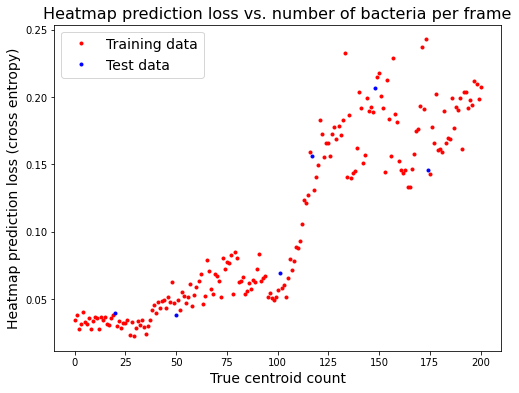

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(centroid_counts_train, heatmap_losses_train, 'r.', label='Training data')
plt.plot(centroid_counts_test, heatmap_losses_test, 'b.', label='Test data')
plt.xlabel('True centroid count', fontsize=14)
plt.ylabel('Heatmap prediction loss (cross entropy)', fontsize=14)
plt.title('Heatmap prediction loss vs. number of bacteria per frame', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('heatmap_loss_vs_centroid_count.pdf', bbox_inches='tight')

In [ ]:
# Oh yea, grab some more pics for report

img = 0

# Predicted
pred = np.reshape((model.predict(features[img:img+1,:,:,:])), (1024, 1024))
plt.figure(figsize=(8,8))
# plt.imshow(pred, cmap='hot')

# Label
plt.figure(figsize=(8,8))
# plt.imshow(labels[img,:,:,0], cmap='hot')

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [ ]:
# ====================================
# Heatmap to centroid prediction:
# Local search/clustering approach
# ====================================

def build_cluster(cur_idx, idxs_remaining, radius=3):
  # Explore square region of fixed size around cur_idx
  # If nothing, just return empty list
  # If you find anything, recursively call build_cluster
  # and return list of indices to add to cluster

  # Note the return value excludes cur_idx itself!
  # and assume cur_idx is already removed from idxs_remaining!

  x, y = cur_idx
  local_members = []
  all_new_members = []

  if idxs_remaining == []:
    return []
  
  for i in range(-radius, radius+1):
    for j in range(-radius, radius+1):
      nx, ny = x+i, y+j
      if (nx, ny) in idxs_remaining: # Found something!
        
        # Before we recurse, add all surrounding points
        # (that are not already accounted for)
        local_members.append((nx, ny))
        all_new_members.append((nx, ny))
        idxs_remaining.remove((nx, ny))
  
  for (nx, ny) in local_members:
        
    # Second pass: now recurse and add new points
    more_members = build_cluster((nx, ny), idxs_remaining, radius)
    all_new_members += more_members
  
  return all_new_members

def find_cluster_center(cluster, img):
  
  best_idx = cluster[0]
  max_intensity = 0

  for idx in cluster:
    intensity = img[idx]
    if intensity > max_intensity:
      max_intensity = intensity
      best_idx = idx
  
  return best_idx

def predict_centroids(heatmap, intensity_threshold = 0.75):
  # Produces list of centroids from heatmap
  idxs_interest = np.argwhere(heatmap > intensity_threshold)  
  idxs_remaining = [tuple(idx) for idx in idxs_interest] # List copy
  clusters = []
  for cur_idx in idxs_interest:
    cur_idx = tuple(cur_idx)
    # Already counted in previous cluster
    if cur_idx not in idxs_remaining:
      continue
    # Create new cluster    
    idxs_remaining.remove(cur_idx)
    cluster = build_cluster(cur_idx, idxs_remaining, radius=2)
    cluster.append(cur_idx)
    # Add new cluster to list of clusters
    clusters.append(cluster)
  centroids = [find_cluster_center(cluster, cpy) for cluster in clusters]
  return centroids

In [ ]:
# Now, want to do the same thing but for centroid count and coordinate loss

# Start with an example, as always
# Decide to use fixed threshold of 0.75 and cluster build "radius" 2

cpy = np.copy(pred)

centroids = predict_centroids(cpy, 0.75)
print("There are %s predicted centroids" % len(centroids))

cpy_heatmap = np.copy(pred)
cpy_orig = np.copy(features[img,:,:,0])
cpy_orig_c2 = np.zeros(features[img,:,:,0].shape)

for x, y in centroids:
  cpy_heatmap[x-5:x+5,y-5:y+5] = 0
  cpy_orig_c2[x-5:x+5,y-5:y+5] = 200

cpy_orig_c3 = np.zeros(features[img,:,:,0].shape)

print("There are %s real centroids" % len(real_centroids[img]))

for y, x in real_centroids[img]:
  cpy_orig_c3[x-5:x+5,y-5:y+5] = 200

cpy_orig_labelled = np.dstack([cpy_orig, cpy_orig_c2, cpy_orig_c3])

plt.figure()
plt.imshow(cpy_heatmap, cmap='hot')

plt.figure()
plt.imshow(cpy_orig_labelled)

In [ ]:
all_centroids = []

for i in range(len(features)):
  feature = features[i:i+1,:,:,:]
  pred_heatmap = np.reshape((model.predict(feature)), (1024, 1024))
  centroids = predict_centroids(pred_heatmap, 0.75)
  all_centroids.append(centroids)
  print("Finished feature %i" % i)

# Pickle them centroids since they took so long...
import pickle
centroid_pred_file = open('centroid_predictions.pkl', 'wb')
pickle.dump(all_centroids, centroid_pred_file)

In [ ]:
# For coordinates loss, I was thinking Jaccard index with small radius
# for two coordinates to be considered the same.

# But if I need to compute distances to nearest neighbor in other set
# anyways, might as well include that distance information.

real_coords = real_centroids[0]
pred_coords = all_centroids[0]

real_coords

In [ ]:
centroid_counts_loss_train = []
centroid_coords_loss_train = []
centroid_counts_train = []

centroid_counts_loss_test = []
centroid_coords_loss_test = []
centroid_counts_test = []

for idx in count_ordered_idxs: # these are OLD indices
  real_coords = real_centroids[idx]
  real_count = count_ordered_idxs[idx]
  if real_count != len(real_coords):
    print("Something is sketchy")
  pred_coords = all_centroids[idx]
  pred_count = len(pred_coords)

  diff_count = real_count - pred_count # Difference between real and predicted
  # Jaccard index?

  if idx in train_indices:
    centroid_counts_loss_train.append(diff_count)
    centroid_coords_loss_train.append()
    centroid_counts_train.append(real_count)
  elif idx in test_indices:
    centroid_counts_loss_test.append(diff_count)
    centroid_coords_loss_test.append()
    centroid_counts_test.append(real_count)

In [ ]:
# ====================================
# Run the NN!
# ====================================
for regularizer in ['None', 'l1', 'l2']:
    for learning_rate in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 100]:
        print('========================')
        print('learning rate = ' + str(learning_rate))
        print('regularizer = ' + regularizer)        
        

        model = create_UNet(np.shape(train_features), 16, regularizer, learning_rate)
        print(model.fit(train_features[:,:,:,:], train_labels[:,:,:,:], epochs=16, batch_size=4, validation_split=0.1))

        train_features2 = model.predict(train_features, batch_size=4)
        model2 = create_UNet(np.shape(train_features2), 16, regularizer, learning_rate)
        print(model2.fit(train_features2, train_labels, epochs=16, batch_size=4, validation_split=0.1))
        print('========================')


In [ ]:
model = create_UNet(np.shape(train_features), 16, None, 0.01)
model.fit(train_features[:,:,:,:], train_labels[:,:,:,:], epochs=16, batch_size=4, validation_split=0.1)

# train_features2 = model.predict(train_features, batch_size=4)
# model2 = create_UNet(np.shape(train_features2), 16, None, 0.01)
# model2.fit(train_features2, train_labels, epochs=16, batch_size=4, validation_split=0.1)

Train on 351 samples, validate on 39 samples
Epoch 1/16
351/351 [==============================] - 32s 90ms/sample - loss: 4.3452 - true_positives_2: 1811108.0000 - precision_2: 0.2838 - recall_2: 0.0206 - val_loss: 0.2265 - val_true_positives_2: 251998.0000 - val_precision_2: 0.9966 - val_recall_2: 0.0142
Epoch 2/16
351/351 [==============================] - 31s 89ms/sample - loss: 0.1280 - true_positives_2: 1362015.0000 - precision_2: 0.9878 - recall_2: 0.0155 - val_loss: 0.2201 - val_true_positives_2: 255060.0000 - val_precision_2: 0.9975 - val_recall_2: 0.0144
Epoch 3/16
351/351 [==============================] - 31s 89ms/sample - loss: 0.1232 - true_positives_2: 2627822.0000 - precision_2: 0.9950 - recall_2: 0.0299 - val_loss: 0.2120 - val_true_positives_2: 1351069.0000 - val_precision_2: 0.9975 - val_recall_2: 0.0761
Epoch 4/16
351/351 [==============================] - 31s 89ms/sample - loss: 0.1193 - true_positives_2: 7726442.0000 - precision_2: 0.9975 - recall_2: 0.0879 - val_

KeyboardInterrupt: ignored

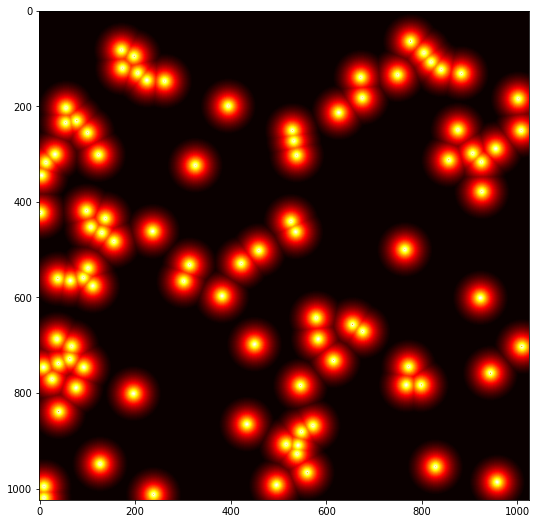

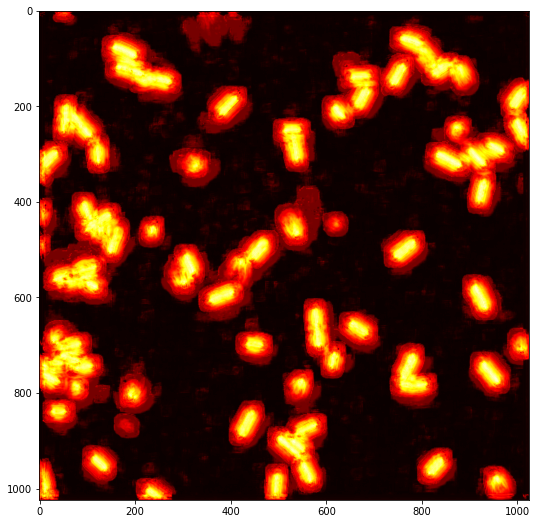

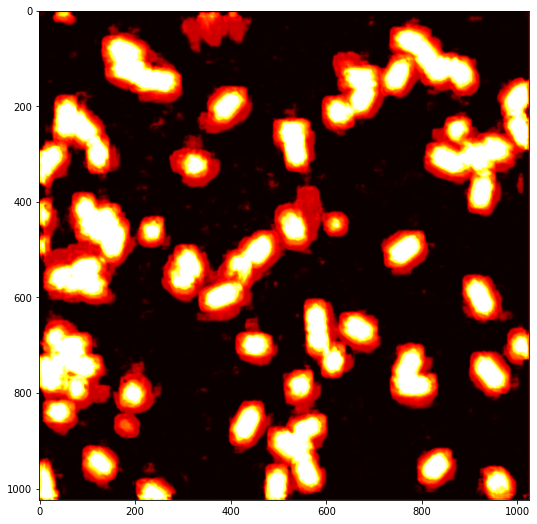

In [ ]:
img = 200

plt.figure(figsize=(9,9))
plt.imshow(new_labels[img,:,:,0], cmap='hot')
# Predicted image
pred = np.reshape((model.predict(new_features[img:img+1,:,:,:])), (1024, 1024))
plt.figure(figsize=(9,9))
plt.imshow(pred, cmap='hot')

# Refined image
pred = np.reshape(pred, (1, 1024, 1024, 1))
pred = np.reshape((model2.predict(pred)), (1024, (1024)))
plt.figure(figsize=(9,9))
plt.imshow(pred, cmap='hot')

In [ ]:
# June 18, 2020
# loss: 0.0978 - precision: 0.9983 - recall: 0.1101 - val_loss: 0.1819 - val_precision: 0.9979 - val_recall: 0.1309

In [ ]:
# ====================================
# Try prediction
# ====================================

# Let train data be everything except
# 1 - 202, 43 - 244, 87 - 288, 122 - 323, 160 - 361, 199 - 400

img = 1

# features = train_features
# labels = train_labels

# Predicted image
pred = np.reshape((model.predict(new_features[img:img+1,:,:,:])), (1024, 1024))
plt.figure(figsize=(9,9))
plt.imshow(pred, cmap='hot')

# Refined image
pred = np.reshape(pred, (1, 1024, 1024, 1))
pred = np.reshape((model2.predict(pred)), (1024, (1024)))
plt.figure(figsize=(9,9))
plt.imshow(pred, cmap='hot')

# Label
plt.figure(figsize=(9,9))
plt.imshow(new_labels[img,:,:,0], cmap='hot')

# Original image
plt.figure(figsize=(9,9))
plt.imshow(train_features[img,:,:,0], cmap='gray')

In [ ]:
def plot_hist(img): # Examine intensity histogram
  plt.figure()
  plt.hist(img.ravel(), bins = 100, log = False)
  plt.show()

In [ ]:
plot_hist(pred)

In [ ]:
def build_cluster(cur_idx, idxs_remaining):
  # Explore square region of fixed size around cur_idx
  # If nothing, just return empty list
  # If you find anything, recursively call build_cluster
  # and return list of indices to add to cluster

  # Note the return value excludes cur_idx itself!
  # and assume cur_idx is already removed from idxs_remaining!

  x, y = cur_idx
  local_members = []
  all_new_members = []

  if idxs_remaining == []:
    return []
  
  for i in range(-4, 5):
    for j in range(-4, 5):
      nx, ny = x+i, y+j
      if (nx, ny) in idxs_remaining: # Found something!
        
        # Before we recurse, add all surrounding points
        # (that are not already accounted for)
        local_members.append((nx, ny))
        all_new_members.append((nx, ny))
        idxs_remaining.remove((nx, ny))
  
  for (nx, ny) in local_members:
        
    # Second pass: now recurse and add new points
    more_members = build_cluster((nx, ny), idxs_remaining)
    all_new_members += more_members
  
  return all_new_members

In [ ]:
# ====================================
# Heatmap to centroid prediction:
# Local search/clustering approach
# ====================================

# utilities
cpy = np.copy(pred)

idxs_interest = np.argwhere(cpy>0.75)

clusters = []
idxs_remaining = [tuple(idx) for idx in idxs_interest] # List copy

for cur_idx in idxs_interest:

  cur_idx = tuple(cur_idx)

  # Already counted in previous cluster
  if cur_idx not in idxs_remaining:
    continue
  
  # Create new cluster    
  idxs_remaining.remove(cur_idx)
  cluster = build_cluster(cur_idx, idxs_remaining)
  cluster.append(cur_idx)
  
  # Add new cluster to list of clusters
  clusters.append(cluster)

In [ ]:
def find_cluster_center(cluster, img):
  
  best_idx = cluster[0]
  max_intensity = 0

  for idx in cluster:
    intensity = img[idx]
    if intensity > max_intensity:
      max_intensity = intensity
      best_idx = idx
  
  return best_idx

In [ ]:
# ====================================
# Alternative Heatmap to centroid prediction:
# Mean-shift clustering method
# ====================================

def wrapper_index(item):
    return item[0] * 1024 + item[1]

    
def dist_squared(p1, p2):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2


def mean_shift(current_point, points, visited_pixels, radius, epsilon):
    if visited_pixels[current_point[0], current_point[1]] == 1:
        return None
    visited_pixels[current_point[0], current_point[1]] = 1
    
    weighted_centroid = np.zeros((2))
    normalizer = 0
    for x in range(current_point[0] - radius, current_point[0] + radius):
        for y in range(current_point[1] - radius,current_point[1] + radius):
            if x >= 0 and y >= 0 and x < 1024 and y < 1024:
                if dist_squared(current_point, [x, y]) <= radius ** 2:
                    weighted_centroid[0] += x * points[x, y]
                    weighted_centroid[1] += y * points[x, y]
                    normalizer += points[x, y]

    weighted_centroid /= (normalizer + epsilon)
    weighted_centroid[0] = int(weighted_centroid[0])
    weighted_centroid[1] = int(weighted_centroid[1])
    weighted_centroid = weighted_centroid.astype('uint32')

    if weighted_centroid[0] == current_point[0] and weighted_centroid[1] == current_point[1]:
        return current_point

    return mean_shift(weighted_centroid, points, visited_pixels, radius, epsilon)


def get_extreme_values(point, heat_map, radius):
    cur_max = heat_map[point[0], point[1]]
    cur_centroid = point
    for x in range(point[0] - radius, point[0] + radius):
        for y in range(point[1] - radius, point[1] + radius):
            if dist_squared(point, [x, y]) <= radius ** 2:
                if x >= 0 and y >= 0 and x < 1024 and y < 1024:
                    if heat_map[x,y] > cur_max:
                        cur_max = heat_map[x,y]
                        cur_centroid = [x, y]
    return cur_centroid

In [ ]:
def mean_shift_cluster(img, verbose = False):
    threshold = 0.65
    radius = 5
    extrema_radius = 10
    centroids_alt = list()
    visited_pixels = np.zeros((1024, 1024))
    pred = np.reshape(model.predict(new_features[img:img+1,:,:,:]), (1024, 1024))

    for x in range(1024):
        for y in range(1024):
            if pred[x, y] > threshold:
                cur_centroid = mean_shift(np.array((x, y)), pred, visited_pixels, radius, 1e-10)
                if cur_centroid is not None:
                    centroids_alt.append(cur_centroid)

        if (x % 100 == 99 or x == 1023) and verbose:
            print(str(x + 1) + ' columns done')

    new_centroids = sorted([get_extreme_values([x, y], pred, extrema_radius) for x, y in centroids_alt], key=wrapper_index)
    centroids_alt = list()

    for x, y in new_centroids:
        create_centroid = True
        for x2, y2 in centroids_alt:
            if abs(x - x2) < extrema_radius * 2 and abs(y - y2) < extrema_radius:
                create_centroid = False
                break
        if create_centroid:
            centroids_alt.append([x, y])

    return centroids_alt


[(16, 616), (48, 400), (55, 916), (95, 225), (104, 794), (117, 694), (117, 907), (123, 566), (129, 767), (132, 908), (148, 972), (144, 783), (153, 736), (157, 798), (161, 777), (188, 564), (191, 98), (196, 1002), (231, 191), (253, 997), (315, 502), (322, 336), (342, 1022), (354, 944), (360, 224), (377, 515), (403, 252), (413, 132), (440, 176), (446, 212), (452, 847), (453, 610), (468, 564), (485, 103), (486, 324), (491, 507), (492, 815), (511, 83), (520, 436), (526, 50), (530, 143), (527, 71), (567, 328), (583, 267), (655, 518), (666, 24), (672, 674), (677, 56), (730, 56), (747, 90), (759, 751), (762, 698), (768, 112), (768, 24), (804, 406), (818, 47), (818, 464), (845, 127), (849, 22), (868, 243), (887, 909), (938, 979), (1005, 569), (1007, 686), (1019, 492)]
There are 65 predicted centroids


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


There are 85 real centroids


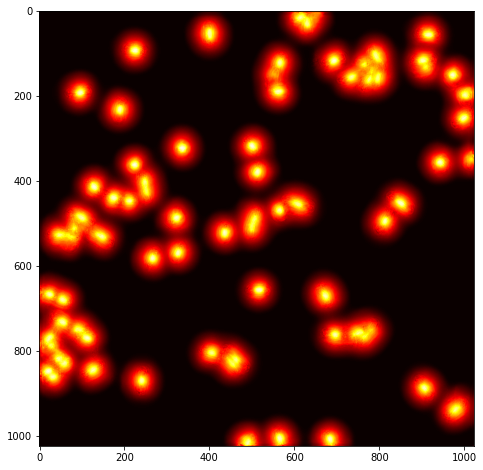

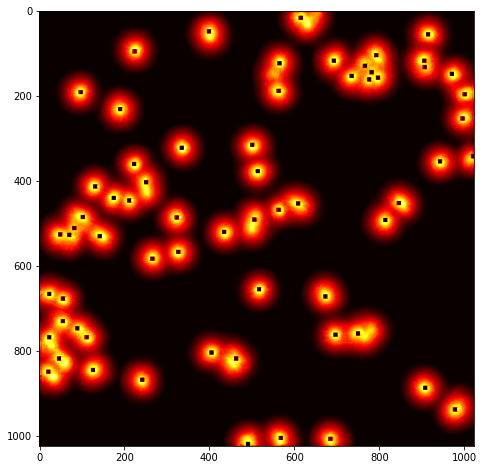

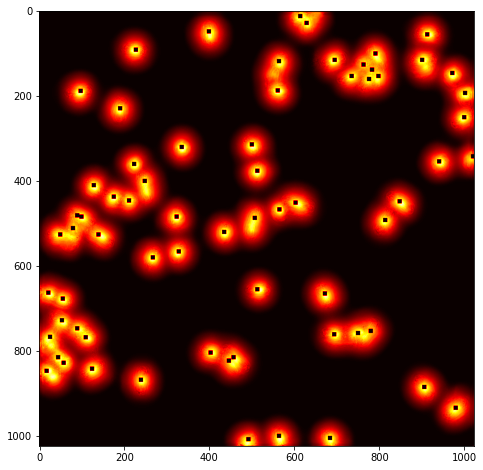

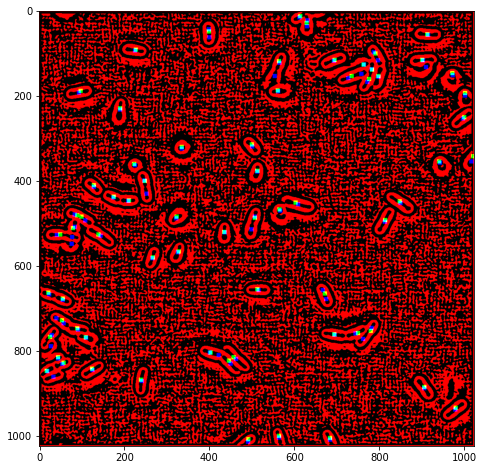

In [ ]:
# Centroid predictions
img = 188
centroids = [find_cluster_center(cluster, cpy) for cluster in clusters]
centroids_alt = mean_shift_cluster(img)
print(centroids)
print("There are %s predicted centroids" % len(centroids))

pred = np.reshape(model.predict(new_features[img:img+1,:,:,:]), (1024, 1024))
cpy_heatmap = np.copy(pred)
cpy_heatmap2 = np.copy(pred)
cpy_orig = np.copy(new_features[img,:,:,0])
cpy_orig_c2 = np.zeros(new_features[img,:,:,0].shape)

real_images = get_images('newFrames/')
# img_gray = cv2.cvtColor(real_images[img], cv2.COLOR_BGR2GRAY) # Convert to grayscale
# cpy_super_orig = np.copy(img_gray)

for x, y in centroids:
  cpy_heatmap[x-5:x+5,y-5:y+5] = 0
  # cpy_orig_c2[x-5:x+5,y-5:y+5] = 200
#  cpy_super_orig[x-5:x+5,y-5:y+5] = 0

for x, y in centroids_alt:
    cpy_heatmap2[x-5:x+5,y-5:y+5] = 0
    cpy_orig_c2[x-5:x+5,y-5:y+5] = 200

cpy_orig_c3 = np.zeros(new_features[img,:,:,0].shape)


real_centroids = get_centroids('newCentroids/')


print("There are %s real centroids" % len(real_centroids[img]))


for y, x in real_centroids[img]:
  cpy_orig_c3[x-5:x+5,y-5:y+5] = 200


cpy_orig_labelled = np.dstack([cpy_orig, cpy_orig_c2, cpy_orig_c3])
# cpy_super_orig_labelled = np.dstack([cpy_super_orig, cpy_orig_c2, cpy_orig_c3])

plt.figure(figsize=(8,8))
plt.imshow(pred, cmap='hot')

plt.figure(figsize=(8,8))
plt.imshow(cpy_heatmap, cmap='hot')

plt.figure(figsize=(8,8))
plt.imshow(cpy_heatmap2, cmap='hot')

plt.figure(figsize=(8, 8))
plt.imshow(cpy_orig_labelled)

# plt.figure(figsize=(8, 8))
# plt.imshow(cpy_super_orig)

In [ ]:
real_centroids = get_centroids('newCentroids/')
centroid_counts = get_centroid_counts(real_centroids)

pred_centroids_counts = list()
for i in range(new_features.shape[0]):
    centroids_alt = mean_shift_cluster(i)
    pred_centroids_counts.append(len(centroids_alt))
    print(i + 1, 'images processed')

No handles with labels found to put in legend.


0 -1
1 0
2 0
3 -2
4 -1
5 0
6 0
7 1
8 0
9 -1
10 0
11 0
12 0
13 1
14 0
15 0
16 0
17 0
18 0
19 1
20 -1
21 0
22 0
23 -1
24 1
25 1
26 0
27 1
28 0
29 0
30 1
31 -1
32 0
33 0
34 0
35 1
36 1
37 1
38 0
39 0
40 1
41 0
42 0
43 0
44 1
45 1
46 0
47 0
48 0
49 0
50 -1
51 0
52 -1
53 -2
54 1
55 -1
56 1
57 0
58 2
59 0
60 -2
61 -2
62 0
63 -1
64 0
65 0
66 1
67 0
68 -2
69 1
70 0
71 0
72 0
73 0
74 0
75 -1
76 -2
77 0
78 0
79 -3
80 0
81 1
82 1
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 1
91 -1
92 1
93 -1
94 0
95 1
96 1
97 0
98 0
99 -2
100 -1
101 0
102 -2
103 -1
104 -1
105 2
106 -3
107 -3
108 -3
109 -3
110 -5
111 2
112 -4
113 -1
114 -1
115 0
116 0
117 -6
118 -3
119 -5
120 -3
121 -7
122 -5
123 -3
124 -2
125 -5
126 -2
127 -1
128 -1
129 -6
130 1
131 -2
132 -1
133 -1
134 -4
135 -6
136 -5
137 -6
138 -5
139 -7
140 -8
141 0
142 -7
143 -8
144 -15
145 -4
146 -13
147 -2
148 -9
149 -12
150 1
151 -2
152 -3
153 2
154 -2
155 -2
156 -2
157 -1
158 2
159 1
160 2
161 -1
162 -2
163 -3
164 -1
165 -1
166 1
167 0
168 -2
169 -2
170 -7
171

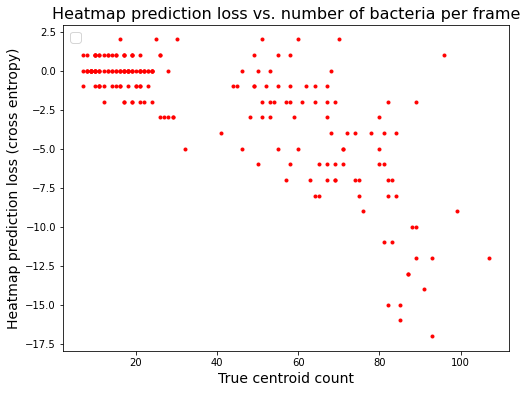

In [ ]:
plt.figure(figsize=(8,6))
for i in range(201):
    print(i, pred_centroids_counts[i] - centroid_counts[i])
plt.plot(centroid_counts, np.array(pred_centroids_counts[:201]) - np.array(centroid_counts), 'r.')
plt.xlabel('True centroid count', fontsize=14)
plt.ylabel('Heatmap prediction loss (cross entropy)', fontsize=14)
plt.title('Heatmap prediction loss vs. number of bacteria per frame', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('heatmap_loss_vs_centroid_count_mean_shift.pdf', bbox_inches='tight')